In [1]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

In [12]:
from PIL import Image, ImageDraw

width = 8
im = Image.new("RGB", (10, width))
draw = ImageDraw.Draw(im)
draw.rectangle([2, 2, 4, 4], fill=(255, 255, 255))

np.array(im).shape

(8, 10, 3)

In [14]:
from gym import spaces

DICT_SPACE = spaces.Dict({
    "sensors": spaces.Dict({
        "position": spaces.Box(low=-100, high=100, shape=(3, )),
        "velocity": spaces.Box(low=-1, high=1, shape=(3, )),
        "front_cam": spaces.Tuple(
            (spaces.Box(low=0, high=1, shape=(10, 10, 3)),
             spaces.Box(low=0, high=1, shape=(10, 10, 3)))),
        "rear_cam": spaces.Box(low=0, high=1, shape=(10, 10, 3)),
    }),
    "inner_state": spaces.Dict({
        "charge": spaces.Discrete(100),
        "job_status": spaces.Dict({
            "task": spaces.Discrete(5),
            "progress": spaces.Box(low=0, high=100, shape=()),
        })
    })
})

DICT_SPACE.sample()

OrderedDict([('inner_state',
              OrderedDict([('charge', 81),
                           ('job_status',
                            OrderedDict([('progress',
                                          array(71.97399, dtype=float32)),
                                         ('task', 4)]))])),
             ('sensors',
              OrderedDict([('front_cam',
                            (array([[[0.4819063 , 0.58392537, 0.675153  ],
                                     [0.46868357, 0.7858202 , 0.6750816 ],
                                     [0.20493703, 0.9489143 , 0.6831409 ],
                                     [0.34620473, 0.6893068 , 0.4391461 ],
                                     [0.12595852, 0.9381866 , 0.9365481 ],
                                     [0.2791781 , 0.04616365, 0.87652844],
                                     [0.03072864, 0.9140525 , 0.72281194],
                                     [0.5361263 , 0.67712224, 0.41093606],
                               

In [3]:
inputs = tf.keras.layers.Input(shape=(128,), name="observations")
last_layer = inputs
# filters = (
#     (),
#     (),
#     (),
# )
# for i, (out_size, kernel, stride) in enumerate(filters[:-1], 1):
#             last_layer = tf.keras.layers.Conv2D(
#                 out_size,
#                 kernel,
#                 strides=(stride, stride),
#                 activation=activation,
#                 padding="same",
#                 name="conv{}".format(i))(last_layer)
value_out = tf.keras.layers.Dense(
    1, name="value_out", activation=None)(last_layer)
model = tf.keras.Model(inputs, [value_out])

# x = tf.random.normal((1, 128))
x = np.random.random_sample((3, 128))
model.predict(x)



array([[0.1819662 ],
       [0.28809145],
       [0.8952887 ]], dtype=float32)

In [104]:
import torch
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical

# m = Categorical(torch.tensor([0.0]), torch.tensor([1.0]))
m = Categorical(torch.tensor([ 0.1, 0.25, 0.25, 0.25 ]))
a = m.sample()
print(a)
m.log_prob(a)

# from gym import error, spaces

# x = spaces.Tuple(
#             (spaces.Discrete(1), spaces.Box(low=0, high=1, shape=(1,)))
#         )
# for s in x:
#     print(s)


# a = torch.rand(1, 3, 3)
# b = torch.rand(1, 3, 3)
# c = torch.rand(1, 4)
# print(a, b, c)

# z = torch.cat((a.view(-1), b.view(-1), c.view(-1)), dim=0)
# a, b = torch.split(z, 2*3*3, dim=0)
# print(a.view(2,3,3), b.view(1,4))


tensor(1)


tensor(-1.2238)

In [44]:
FixedNormal = torch.distributions.Normal

def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

class AddBias(nn.Module):
    def __init__(self, bias):
        super(AddBias, self).__init__()
        self._bias = nn.Parameter(bias.unsqueeze(1))

    def forward(self, x):
        if x.dim() == 2:
            bias = self._bias.t().view(1, -1)
        else:
            bias = self._bias.t().view(1, -1, 1, 1)

        return x + bias

class DiagGaussian(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DiagGaussian, self).__init__()

        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0))

        self.fc_mean = init_(nn.Linear(num_inputs, num_outputs))
        self.logstd = AddBias(torch.zeros(num_outputs))

    def forward(self, x):
        action_mean = self.fc_mean(x)

        #  An ugly hack for my KFAC implementation.
        zeros = torch.zeros(action_mean.size())
        if x.is_cuda:
            zeros = zeros.cuda()

        action_logstd = self.logstd(zeros)
        print(action_mean, action_logstd.exp())
        return FixedNormal(action_mean, action_logstd.exp())

m = DiagGaussian(512, 2)
x = torch.rand((1, 512))
dist = m(x)
dist.sample()[0]

tensor([[0.6656, 1.2110]], grad_fn=<AddmmBackward>) tensor([[1., 1.]], grad_fn=<ExpBackward>)


tensor([1.0341, 1.2150])

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class NNBase(nn.Module):
    def __init__(self, recurrent, recurrent_input_size, hidden_size):
        super(NNBase, self).__init__()

        self._hidden_size = hidden_size
        self._recurrent = recurrent

        if recurrent:
            self.gru = nn.GRU(recurrent_input_size, hidden_size)
            for name, param in self.gru.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0)
                elif 'weight' in name:
                    nn.init.orthogonal_(param)

    @property
    def is_recurrent(self):
        return self._recurrent

    @property
    def recurrent_hidden_state_size(self):
        if self._recurrent:
            return self._hidden_size
        return 1

    @property
    def output_size(self):
        return self._hidden_size

    def _forward_gru(self, x, hxs, masks):
        if x.size(0) == hxs.size(0):
            x, hxs = self.gru(x.unsqueeze(0), (hxs * masks).unsqueeze(0))
            x = x.squeeze(0)
            hxs = hxs.squeeze(0)
        else:
            # x is a (T, N, -1) tensor that has been flatten to (T * N, -1)
            N = hxs.size(0)
            T = int(x.size(0) / N)

            # unflatten
            x = x.view(T, N, x.size(1))

            # Same deal with masks
            masks = masks.view(T, N)

            # Let's figure out which steps in the sequence have a zero for any agent
            # We will always assume t=0 has a zero in it as that makes the logic cleaner
            has_zeros = ((masks[1:] == 0.0) \
                            .any(dim=-1)
                            .nonzero()
                            .squeeze()
                            .cpu())

            # +1 to correct the masks[1:]
            if has_zeros.dim() == 0:
                # Deal with scalar
                has_zeros = [has_zeros.item() + 1]
            else:
                has_zeros = (has_zeros + 1).numpy().tolist()

            # add t=0 and t=T to the list
            has_zeros = [0] + has_zeros + [T]

            hxs = hxs.unsqueeze(0)
            outputs = []
            for i in range(len(has_zeros) - 1):
                # We can now process steps that don't have any zeros in masks together!
                # This is much faster
                start_idx = has_zeros[i]
                end_idx = has_zeros[i + 1]

                rnn_scores, hxs = self.gru(
                    x[start_idx:end_idx],
                    hxs * masks[start_idx].view(1, -1, 1))

                outputs.append(rnn_scores)

            # assert len(outputs) == T
            # x is a (T, N, -1) tensor
            x = torch.cat(outputs, dim=0)
            # flatten
            x = x.view(T * N, -1)
            hxs = hxs.squeeze(0)

        return x, hxs

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

    
class MyCNNBase(NNBase):
    def __init__(self, num_inputs, recurrent=False, hidden_size=512):
        super(MyCNNBase, self).__init__(recurrent, hidden_size, hidden_size)
        
        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0), nn.init.calculate_gain('relu'))

        self.main = nn.Sequential(
            init_(nn.Conv2d(num_inputs, 8, 3, padding=1)), nn.ReLU(),
            init_(nn.Conv2d(8, 16, 3, padding=1)), nn.ReLU(),
            init_(nn.Conv2d(16, 16, 3, padding=1)), nn.ReLU(), Flatten(),
            init_(nn.Linear(16 * 64 * 64, hidden_size)), nn.ReLU()
        )

        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0))

        self.critic_linear = init_(nn.Linear(hidden_size, 1))

        self.train()

    def forward(self, inputs, rnn_hxs=None, masks=None):
        x = self.main(inputs)
        print(x.shape)

        if self.is_recurrent:
            x, rnn_hxs = self._forward_gru(x, rnn_hxs, masks)

        return self.critic_linear(x), x, rnn_hxs
    
model = MyCNNBase(2)
x = torch.rand((1,2,64,64))
model(x)

torch.Size([1, 512])


(tensor([[-0.0660]], grad_fn=<AddmmBackward>),
 tensor([[1.5559e-01, 0.0000e+00, 5.7034e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          2.3859e-01, 1.3613e-01, 0.0000e+00, 4.0418e-01, 1.3930e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7842e-01, 0.0000e+00,
          1.4629e-01, 4.0659e-01, 0.0000e+00, 8.1873e-02, 0.0000e+00, 2.7271e-01,
          0.0000e+00, 2.5336e-02, 2.9167e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.7672e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 8.6499e-02, 1.9165e-01, 0.0000e+00, 0.0000e+00,
          3.3851e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7363e-01,
          0.0000e+00, 4.1223e-01, 5.3494e-01, 0.0000e+00, 0.0000e+00, 3.0614e-01,
          8.4542e-01, 0.0000e+00, 4.5288e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          3.9042e-01, 2.4990e-01, 1.8739e-01, 0.0000e+00, 8.3376e-02, 0.0000e+00,
          1.2821e-01, 0.0000e+00, 0.0000e+00, 2.356

In [3]:
# %cd /notebooks/LearningToPaint/gym-canvas
# !pip uninstall -e .
# !python setup.py develop -u


import gym
from baselines.common.vec_env.util import dict_to_obs, obs_space_info, obs_to_dict

import sys
sys.path.append("/notebooks/LearningToPaint/gym-canvas")
import gym_canvas

env = gym.make('gym_canvas:canvas-v0')
obs_space_info(env.observation_space)


([None], {None: (2, 64, 64)}, {None: dtype('float64')})

In [33]:
import numpy as np
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms


transform = transforms.ToTensor()

width = 8

im = Image.new("L", (width, width))
draw = ImageDraw.Draw(im)
draw.rectangle([2, 2, 4, 4], fill=255)
im1 = transform(im)

im = Image.new("L", (width, width))
draw = ImageDraw.Draw(im)
draw.rectangle([2, 2, 4, 4], fill=255)
im2 = transform(im)


# x, y = np.random.randint(2, size=2)
# x
# type(y)

torch.cat((im1, im2), 0).shape

torch.Size([2, 8, 8])

[0.51668862 0.95724724 0.72099625 0.01031905 0.86510212 0.86782502
 0.52789141 0.46370278 0.23791292 0.73075442]


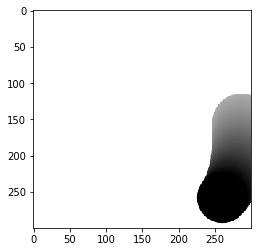

In [1]:
%matplotlib inline

import numpy as np
import cv2
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt

from Renderer.stroke_gen import draw

f = np.random.uniform(0, 1, 10)
print(f)
im = draw(f, 300)

plt.imshow(im, cmap='gray')

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]


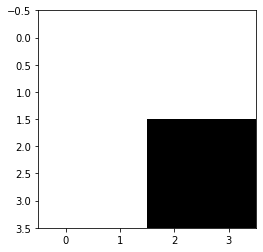

In [2]:
from PIL import Image, ImageDraw
from Renderer.stroke_gen import draw_rect

# width = 3
# im = Image.new('F', (width, width))

# draw = ImageDraw.Draw(im)
# # draw.line((0, 0) + im.size, fill=128)
# # draw.line((0, im.size[1], im.size[0], 0), fill=128)
# draw.rectangle([1, 1, 2, 2], fill=1)
# # plt.imshow(np.array(im), cmap='gray')
# plt.imshow(im, vmin=0, vmax=1)

im = draw_rect([0.5, 0.5, 1, 1], width=4)
# plt.imshow(im, vmin=0, vmax=1)
plt.imshow(1-im, cmap='gray')
print(im)

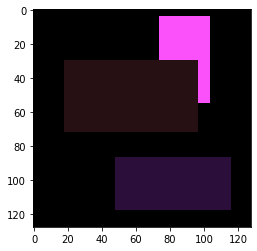

In [103]:
def rand_draw(draw_fn=draw_rect, n_strokes=3, width=128):
    canvas = np.zeros((width, width, 3), dtype=int)
    for i in range(n_strokes):
        x = np.random.rand(4)
        stroke = draw_fn(x, width)
        stroke = np.expand_dims(stroke, axis=2)
        color = np.random.randint(255, size=(3))
        canvas = canvas * (1 - stroke) + stroke * color
    return canvas.astype(int)

plt.imshow(rand_draw(width=128))
# plt.imshow(1-im, cmap='gray')

In [4]:
import torch
from Renderer.model import FCN

action_dim = 4

stroke_net = FCN(num_input=action_dim)
stroke_net.load_state_dict(torch.load("../renderer.pkl"))

# x = torch.rand(1, action_dim)

print(draw_rect([0, 0, 0.5, 0.5]))
x = torch.from_numpy(np.array([[0, 0, 0.5, 0.5]], dtype=np.float32))
print(x.shape)
# x = np.random.rand(action_dim)
stroke_net(x)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([1, 4])


tensor([[[0.4814, 0.5122, 0.4826,  ..., 0.5142, 0.4769, 0.5145],
         [0.4990, 0.4765, 0.4986,  ..., 0.4764, 0.5006, 0.4712],
         [0.4819, 0.5128, 0.4805,  ..., 0.5145, 0.4696, 0.5187],
         ...,
         [0.4925, 0.4770, 0.4874,  ..., 0.4768, 0.4929, 0.4663],
         [0.4892, 0.5084, 0.4898,  ..., 0.5068, 0.4751, 0.5088],
         [0.4923, 0.4687, 0.4823,  ..., 0.4666, 0.4885, 0.4667]]],
       grad_fn=<RsubBackward1>)

finish loading data, 8 training images, 2 testing images


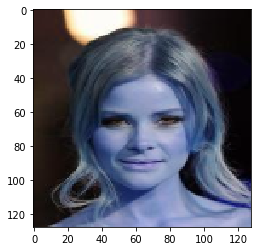

In [26]:
from env import Paint

env = Paint(1, 3)
env.load_data()
obs = env.reset()
obs = env.reset_with_gen()

# print(obs[0, 3:6])
im = np.array(obs[0, 3:6])
plt.imshow(np.transpose(im, (1, 2, 0)))


(128, 128)
torch.Size([1, 128, 128, 1])


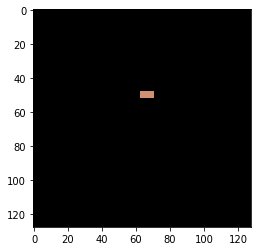

In [63]:
import torch
from Renderer.model import FCN
from Renderer.stroke_gen import draw_rect
# from DRL.ddpg import decode

Decoder = FCN(num_input=action_dim)
Decoder.load_state_dict(torch.load("../renderer.pkl"))

print(draw_rect([0, 0, 1, 1]).shape)

def decode(x, canvas, width=128):
    # x: (B * 5) * (10 + 3), 5: 5 steps, 10+3: action output
    x = x.view(-1, action_dim + 3)
#     stroke = 1 - Decoder(x[:, :action_dim])
    
    # debug: use draw_fn instead
    stroke = []
    for i in range(batch):
        stroke.append(draw_rect(x[i, :action_dim]))
    stroke = torch.tensor(stroke)

    stroke = stroke.view(-1, width, width, 1)  # shape: (b, w, w, 1)
    print(stroke.shape)
#     color_stroke = stroke * x[:, -3:].view(-1, 1, 1, 3)
    color_stroke = stroke * x[:, -3:].view(-1, 1, 1, 3)  # shape: (b, w, w, 3)
#     print(color_stroke.shape)
    stroke = stroke.permute(0, 3, 1, 2).view(-1, n_frames_per_step, 1, width, width)
    color_stroke = color_stroke.permute(0, 3, 1, 2).view(-1, n_frames_per_step, 3, width, width)
    for i in range(n_frames_per_step):
        canvas = canvas * (1 - stroke[:, i]) + color_stroke[:, i]
    return canvas

n_frames_per_step = 1
batch = 1
width = 128

canvas = torch.zeros(batch,3,width,width)# [B x 3 x width x width]

_action = torch.rand(batch, 4)
color = torch.rand(batch, 3)
action = torch.cat((_action, color), 1)

canvas_out =  decode(action, canvas, width)

im = canvas_out.squeeze(0).detach().numpy()
im = np.transpose(im, (1, 2, 0))
# canvas = decode(action, canvas)
plt.imshow(im)

In [120]:
from env import Paint
from DRL.ddpg import DDPG
from utils.util import to_numpy
from utils.tensorboard import TensorBoard

exp = os.path.abspath(".").split("/")[-1]
writer = TensorBoard("../train_log/{}".format(exp))

agent = DDPG(1, 1, 5, 0.001, 0.95 ** 5, 800, writer, None, "./model")

env = Paint(1, 5)
obs = env.reset_with_gen()
agent.reset(obs, 0)
action = agent.select_action(obs, noise_factor=0)
obs, reward, done, _ = env.step(torch.tensor(action))
# env.step()

# print(obs.shape)
# env.gt[0].cpu().data.numpy()
cv = to_numpy(env.canvas[0])



(3, 128, 128)

In [144]:
# x = [np.random.rand(4) for _ in range(3)]
# x = np.stack(x)
# print(x)
# # x.shape

# a = np.random.rand(3)
# print(a)
# b = np.random.rand(4)
# np.concatenate((a,b))
x = torch.tensor([1,2,3,4])
x.view(2, -1)


tensor([[1, 2],
        [3, 4]])